<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/langgraph_bot_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install langchain langgraph langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 4.2 MB/s eta 0:00:00


In [13]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY']=userdata.get('groq_api_key')

In [14]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [15]:
llm.invoke("hi").content

'Hi! 👋\n\nHow can I help you today? 😊\n'

In [16]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [17]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [18]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

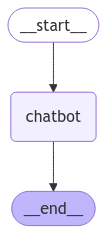

In [19]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
class MessagesState(TypedDict):
    messages: Annotated[list[HumanMessage], add_messages]

In [22]:
input={"messages":["hi, my name is sunny"]}

In [23]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is sunny', additional_kwargs={}, response_metadata={}, id='db0fd729-71a1-449e-9e17-116dcfab3789'),
  AIMessage(content="Hello Sunny, it's nice to meet you!\n\nWhat can I do for you today? 😊  \n\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_time': 0.047272727, 'prompt_time': 9.4479e-05, 'queue_time': 0.021431469999999998, 'total_time': 0.047367206}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-8abf2a28-3afc-40be-9f77-a34230bb2278-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41})]}

In [24]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hello Sunny, it's nice to meet you! 😊\n\nWhat can I do for you today?  \n\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_time': 0.047272727, 'prompt_time': 8.87e-05, 'queue_time': 0.021041419999999998, 'total_time': 0.047361427}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-a3ed5b4c-4e23-4448-bee2-4f571a7d833a-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41})]}




In [25]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [26]:
search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [27]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [28]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x7c6cc8b98680>)

In [29]:
tools=[search]

In [30]:
tool_node=ToolNode(tools)

In [31]:
llm_with_tool=llm.bind_tools(tools)

In [32]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [33]:
response=call_model({"messages": ["hi how are you?"]})

In [34]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sdew', 'function': {'arguments': '{"query":"how are you?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 941, 'total_tokens': 1023, 'completion_time': 0.149090909, 'prompt_time': 0.030202403, 'queue_time': 0.021833577000000003, 'total_time': 0.179293312}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b236e30e-df26-4e10-ac81-a18d6d24dd47-0', tool_calls=[{'name': 'search', 'args': {'query': 'how are you?'}, 'id': 'call_sdew', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 82, 'total_tokens': 1023})]}

[AIMessage(content='I am doing well, thank you. How are you?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 941, 'total_tokens': 955, 'completion_time': 0.025454545, 'prompt_time': 0.030139486, 'queue_time': 0.0028640919999999986, 'total_time': 0.055594031}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-7176e5d9-307e-4644-93e2-99d358198179-0', usage_metadata={'input_tokens': 941, 'output_tokens': 14, 'total_tokens': 955})]

In [35]:
messages = response['messages']

In [36]:
last_message=messages[-1]

In [37]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'how are you?'},
  'id': 'call_sdew',
  'type': 'tool_call'}]

In [38]:
response=call_model({"messages": ["what is a weather in India?"]})

In [39]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_knf3', 'function': {'arguments': '{"query":"weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 943, 'total_tokens': 1025, 'completion_time': 0.149090909, 'prompt_time': 0.030101473, 'queue_time': 0.021166426999999998, 'total_time': 0.179192382}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ac85465f-a0b8-46bc-9c8d-d95eb6411e8e-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'call_knf3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 82, 'total_tokens': 1025})]}

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5q56', 'function': {'arguments': '{"query":"weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 943, 'total_tokens': 1025, 'completion_time': 0.149090909, 'prompt_time': 0.031104902, 'queue_time': 0.003129146000000003, 'total_time': 0.180195811}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-35d08bfe-0844-4902-8d36-71630335dd9e-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'call_5q56', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 82, 'total_tokens': 1025})]

In [40]:
messages = response['messages']

In [41]:
last_message=messages[-1]

In [42]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': 'call_knf3',
  'type': 'tool_call'}]

In [43]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [44]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

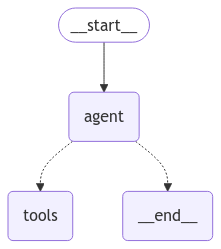

In [45]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [46]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='26b1a7a0-70fc-43a9-9797-7de5b3f1858d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1y18', 'function': {'arguments': '{"query":"hi how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 941, 'total_tokens': 1024, 'completion_time': 0.150909091, 'prompt_time': 0.033695702, 'queue_time': 0.022018852999999998, 'total_time': 0.184604793}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-97126900-e3b8-410b-a5cc-b8e8157f18d7-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi how are you'}, 'id': 'call_1y18', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 83, 'total_tokens': 1024}),
  ToolMessage(content="It's 90 degrees and sunny.", name='search', id='1637481b-57d1-4dab-96bd

In [47]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='60d25e8c-a4b5-4456-8638-b3df441a9241'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wa9h', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 942, 'total_tokens': 1023, 'completion_time': 0.147272727, 'prompt_time': 0.030213012, 'queue_time': 0.021263243999999997, 'total_time': 0.177485739}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e302d60d-b643-43b9-b7d4-4fc6c208c3dc-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'call_wa9h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 81, 'total_tokens': 1023}),
  ToolMessage(content="It's 60 degrees and foggy.", name='search', id='a4e448ca-294f-4

In [48]:
workflow.add_edge("tools", 'agent')

In [49]:
app = workflow.compile()

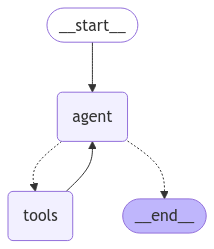

In [50]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [51]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vprv', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 942, 'total_tokens': 1024, 'completion_time': 0.149090909, 'prompt_time': 0.030212883, 'queue_time': 0.022660517, 'total_time': 0.179303792}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ec4d1b1f-d347-4243-9225-71f7b1f60ecc-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'call_vprv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 82, 'total_tokens': 1024})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='e1997265-1c1c-4f42-9967-e1b4e24a1d40', tool_call_id='call_vprv')]}


here is outp

In [52]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [53]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [54]:
app3 = workflow3.compile(checkpointer = memory)

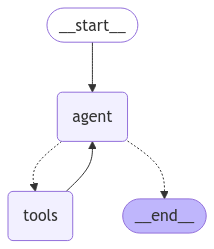

In [55]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
config = {"configurable": {"thread_id": "1"}}

In [57]:
events = app3.stream(
    {"messages": ["Hi there! My name is Sunny."]}, config, stream_mode="values"
)

In [58]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Sunny.
================================== Ai Message ==================================
Tool Calls:
  search (call_6g93)
 Call ID: call_6g93
  Args:
    query: Hello, what is your name?
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny.
================================== Ai Message ==================================

That's not my name. My name is Sunny.


In [59]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [60]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

I don't have access to past conversations.  

What is your name?


In [61]:
memory.get(config)

{'v': 1,
 'ts': '2025-01-21T17:22:56.800500+00:00',
 'id': '1efd81c5-aedf-6f5f-8006-f5c28f492290',
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Sunny.', additional_kwargs={}, response_metadata={}, id='0eac04b3-8fbc-462e-85d0-15ea098c400e'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6g93', 'function': {'arguments': '{"query":"Hello, what is your name?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 944, 'total_tokens': 1029, 'completion_time': 0.154545455, 'prompt_time': 0.051914592, 'queue_time': 0.020473186999999997, 'total_time': 0.206460047}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ffa79354-9ba3-4eda-9ab8-e91c740d98fe-0', tool_calls=[{'name': 'search', 'args': {'query': 'Hello, what is your name?'}, 'id': 'call_6g93', 'type': 'tool_call'}], usage_metadata={'input_

In [62]:
# app.py

In [ ]:
import streamlit as st
from transformers import pipeline
from bot import chatbot

mybot=chatbot()
workflow=mybot()

# Set up the Streamlit app UI
st.title("ChatBot with LangGraph")
st.write("Ask any question, and I'll try to answer it!")

# Input text box for the question
question = st.text_input("Enter your question here:")
input={"messages": [question]}

# Button to get the answer
if st.button("Get Answer"):
    if input:
        response=workflow.invoke(input)
        st.write("**Answer:**", response['messages'][-1].content)
    else:
        st.warning("Please enter a question to get an answer.")

# Additional styling (optional)
st.markdown("---")
st.caption("Powered by Streamlit and Transformers")

In [ ]:
#bot.py
# importing a necessary library
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults



class chatbot:
    def __init__(self):
        self.llm=ChatGroq(model_name="Gemma2-9b-It")

    def call_tool(self):
        tool = TavilySearchResults(max_results=2)
        tools = [tool]
        self.tool_node = ToolNode(tools=[tool])
        self.llm_with_tool=self.llm.bind_tools(tools)

    def call_model(self,state: MessagesState):
        messages = state['messages']
        response = self.llm_with_tool.invoke(messages)
        return {"messages": [response]}

    def router_function(self,state: MessagesState) -> Literal["tools", END]:
        messages = state['messages']
        last_message = messages[-1]
        if last_message.tool_calls:
            return "tools"
        return END



    def __call__(self):
        self.call_tool()
        workflow = StateGraph(MessagesState)
        workflow.add_node("agent", self.call_model)
        workflow.add_node("tools", self.tool_node)
        workflow.add_edge(START, "agent")
        workflow.add_conditional_edges("agent",self.router_function,{"tools": "tools", END: END})
        workflow.add_edge("tools", 'agent')
        self.app = workflow.compile()
        return self.app

if __name__=="__main__":
    mybot=chatbot()
    workflow=mybot()
    response=workflow.invoke({"messages": ["who is a current prime minister of USA?"]})
    print(response['messages'][-1].content)

